In [2]:
# !pip install tslearn
# !pip install torch

In [3]:
import tslearn
import tslearn.datasets as ds
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import copy
import matplotlib.pyplot as plt
from Models.LAFS import *


In [4]:
# ds.UCR_UEA_datasets().list_datasets()

In [5]:
trainX, trainY, testX, testY = ds.UCR_UEA_datasets().load_dataset(
        "MotorImagery")

In [6]:
print(trainX.shape)
print(testX.shape)
print(len(np.unique(trainY))," Classes")

(278, 3000, 64)
(100, 3000, 64)
2  Classes


In [7]:
# plt.plot(trainX[0,...,27])

In [8]:
def get_mean_std(trainX,dim = (0,1)):  ## normalize across subject and time, for each feature (7)
    mean_channel = np.nanmean(trainX,axis = dim, keepdims = True)
    std_channel = np.nanstd(trainX,axis = dim,keepdims =True)
    return mean_channel,std_channel

In [9]:
mean_channel,std_channel = get_mean_std(trainX)
trainX = (trainX - mean_channel)/(std_channel + 1e-8)
testX = (testX - mean_channel)/(std_channel + 1e-8)

In [10]:
## Average Pooling to Reduce and smooth the size of the sequence 
trainX = torch.tensor(trainX)
testX = torch.tensor(testX)

trainX = F.avg_pool1d(trainX.permute(0,2,1),10,10).permute(0,2,1)
trainX = np.array(trainX.detach())

testX = F.avg_pool1d(testX.permute(0,2,1),10,10).permute(0,2,1)
testX = np.array(testX.detach())

In [11]:
### Label encoding 
unique_values = np.unique(trainY)
unique_values = [i for i in unique_values if i is not np.nan]
mapping = {value: idx for idx, value in enumerate(unique_values)}
print(mapping)
for v in unique_values:

    trainY[trainY == v] = mapping[v]
    testY[testY ==v] = mapping[v]
trainY = np.long(trainY)
testY = np.long(testY)

{np.str_('finger'): 0, np.str_('tongue'): 1}


In [12]:
## Simple CNN example
class SimpleCNN_LAFS(nn.Module):
    def __init__(self, input_size,sequence_length,filter_size = 32,kernel_size = 3, depth = 2, n_class = 2, lafs_heads = 4, use_lafs = True):
        super(SimpleCNN_LAFS, self).__init__()
        self.lafs = LAFS(input_size,sequence_length,k = sequence_length, lafs_heads = lafs_heads)
        self.depth = depth
        self.use_lafs = use_lafs
        if use_lafs:
            self.conv_list = nn.Conv1d(lafs_heads,filter_size,kernel_size = kernel_size,padding = 0,bias = True)
        else:
            self.conv_list = nn.Conv1d(input_size,filter_size,kernel_size = kernel_size,padding = 0,bias = True)


        # self.conv_list.weight.data = torch.zeros(self.conv_list.weight.data.shape)

        self.conv_list2 = nn.Conv1d(input_size,filter_size,kernel_size = kernel_size,padding = 0,bias = True)
        # if use_lafs:
        #     self.conv_list.append(nn.Conv1d(lafs_heads,filter_size,kernel_size = kernel_size,padding = 0))
        # else:
        #     self.conv_list.append(nn.Conv1d(input_size,filter_size,kernel_size = kernel_size,padding = 0))

        # for d in range(1,depth):
        #     self.conv_list.append(nn.Conv1d(filter_size,filter_size,kernel_size = kernel_size,padding = 0))

        self.out = nn.Linear(filter_size, n_class)

    def forward(self,x):
        
        ## Input X should be (Batch size, Time Steps,Features)
        if self.use_lafs:
            x, weights = self.lafs(x,training = True)
        else:
            weights = None
        x = x.permute(0,2,1)
        x = self.conv_list(x)
        x = torch.relu(x)
        # for d in range(1,self.depth):
        #     x = self.conv_list[d](x)
        #     x = torch.relu(x)
        

        # x_sum = torch.mean(x*x,dim= 1,keepdims = True)
        # dis,ind = torch.topk(x_sum,dim = -1,k=10)
        # ind = ind.repeat(1,x.shape[1],1)
        # x = torch.gather(x,dim = -1,index = ind)
        x,ind = torch.max(x,dim = -1)
        x = self.out(x)
        return x, weights

In [13]:
def normalized_cross_correlation(x, y, axis=-1):
    assert x.shape == y.shape, "Input tensors must have the same shape"
    
    # Subtract the mean of each tensor along the specified axis
    x_mean = torch.mean(x, dim=axis, keepdim=True)
    y_mean = torch.mean(y, dim=axis, keepdim=True)

    x_centered = x - x_mean
    y_centered = y - y_mean

    # Compute the numerator (sum of element-wise products of centered tensors)
    numerator = torch.sum(x_centered * y_centered, dim=axis)

    # Compute the denominator (sqrt of product of squared norms along the specified axis)
    x_norm = torch.sqrt(torch.sum(x_centered ** 2, dim=axis))
    y_norm = torch.sqrt(torch.sum(y_centered ** 2, dim=axis))
    denominator = x_norm * y_norm

    # Compute the normalized cross-correlation
    ncc = numerator / denominator

    return ncc

In [14]:
#ne simple train function 

def create_data_loaders(X,Y, batch_size = 1, shuffle = False):
    X_torch = torch.Tensor(X).float()
    Y_torch = torch.Tensor(Y).long()
    train = TensorDataset(X_torch,Y_torch) 
    train_data_loader = DataLoader(train, shuffle=shuffle, batch_size = batch_size) 
    return train_data_loader

def train(model, train_dataloader, test_dataloader, lr = .003, num_epochs = 100,early_stopping = 20):
    es = early_stopping
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    max_val_acc = 0.0
    rate = .95
    decay = .95
    shape = model.conv_list.weight.shape
    print(shape)
    loss_shape = []
    initial_weights1=  copy.deepcopy(model.conv_list.weight.view(shape[0],shape[1], -1).detach())
    initial_weights1 = initial_weights1#.detach()
    # plt.plot(initial_weights1[0,0,...].detach())
    # plt.pause(.2)
    # plt.plot(initial_weights1[1,0,...].detach())
    # plt.pause(.2)
    initial_weights1 = initial_weights1/initial_weights1.norm(dim=-1, keepdim=True)


    for epoch in range(num_epochs):
        model.train()
        for i, (x,y) in enumerate(train_dataloader):  
            outputs, weights = model(x)
            loss = loss_function(outputs,y.long())
            # print(model.conv_list.weight.grad)

            weight = model.conv_list.weight.view(shape[0],shape[1], -1)#.detach()#.abs()#.abs()  # Shape: [out_channels, in_channels * kernel_size]
            centered_weight = weight/(weight.norm(dim=-1, keepdim=True) + 1e-8)
            centered_weight = centered_weight.mean(dim =0)
            covariance_initial = torch.sum((initial_weights1*centered_weight),dim =-1).abs()
            # covariance_initial = torch.clamp(covariance_initial,rate,1) - rate
            alpha_new = covariance_initial.mean(dim = 1)
            # alpha_new = covariance_initial.mean()


            # loss = loss + loss*alpha1
            # covariance_initial = torch.sigmoid(covariance_initial) - .5
            alpha1 = alpha_prior.detach() - alpha_new#covariance_initial.mean()
            alpha_prior = alpha_new

            # alpah1 = torch.sigmoid(alpha1) - .5
            loss =  loss - (alpha1.mean())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        rate = rate*decay
        if rate < 0:
            rate = 0
        initial_weights1=  model.conv_list.weight.view(shape[0]*shape[1], -1)#.abs()
        initial_weights1 = initial_weights1/initial_weights1.norm(2,dim=1, keepdim=True)
        initial_weights1 = initial_weights1.detach()
        # weight = model.conv_list.weight.view(shape[0]*shape[1], -1)#.abs()#.abs()  # Shape: [out_channels, in_channels * kernel_size]
        # centered_weight = weight/(weight.norm(dim=1, keepdim=True) + 1e-8)

     

        # weight = model.conv_list.weight.view(shape[0]*shape[1], -1)#.abs()#.abs()  # Shape: [out_channels, in_channels * kernel_size]
        # centered_weight = weight/(weight.norm(dim=1, keepdim=True) + 1e-8)
        # covariance_initial = torch.sum(initial_weights1*centered_weight,dim =1).abs()
        # alpha1 = covariance_initial.mean(dim = 0)
        # print(alpha1)


        val_acc = 0
        output_ = torch.zeros((0))
        labels_ = torch.zeros((0))
        for i, (x,y) in enumerate(test_dataloader):  
            outputs, weights = model(x)
            outputs = torch.argmax(outputs,dim = -1)
            output_ = torch.cat([output_,outputs],axis = 0)
            labels_ = torch.cat([labels_,y],axis = 0)
        val_acc = len(output_[output_ == labels_])/len(output_)
        loss_shape.append(val_acc)
        if (val_acc > max_val_acc):
            es = early_stopping
            print("val accuracy increased from " + str(max_val_acc) + " to " + str(val_acc) + " at epoch " + str(epoch) + ". Saving new model.")
            best_model = copy.deepcopy(model)
            max_val_acc = val_acc
        else:
            es = es - 1
        if es <=0:
            # plt.plot(loss_shape)
            # plt.pause(.2)
            # plt.plot(weight[0,...].detach())
            # plt.pause(.2)
            # plt.plot(weight[1,...].detach())
            # plt.pause(.2)
            break
    return best_model,max_val_acc

In [15]:
x1 = torch.rand((100,7))
x2 = torch.rand((100,7))



In [89]:
## Define simple train function 

def create_data_loaders(X,Y, batch_size = 1, shuffle = False):
    X_torch = torch.Tensor(X).float()
    Y_torch = torch.Tensor(Y).long()
    train = TensorDataset(X_torch,Y_torch) 
    train_data_loader = DataLoader(train, shuffle=shuffle, batch_size = batch_size) 
    return train_data_loader

def train(model, train_dataloader, test_dataloader, lr = .003, num_epochs = 100,early_stopping = 20):
    es = early_stopping
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    max_val_acc = 0.0
    # decay = .9
    shape = model.conv_list.weight.shape
    initial_weights1=  copy.deepcopy(model.conv_list.weight.view(shape[0]*shape[1], -1).detach())
    initial_weights1 = initial_weights1/(initial_weights1.norm(2,dim=-1, keepdim=True)+ 1e-8)

    rate = 1

    avg_train_loss = 1000

    for epoch in range(num_epochs):
        model.train()
        train_loss_epoch = 0
        for i, (x,y) in enumerate(train_dataloader):  
            outputs, weights = model(x)
            loss = loss_function(outputs,y.long())
            # print(model.conv_list.weight.grad)
            weight = model.conv_list.weight.view(shape[0]*shape[1], -1)#.detach()#.abs()#.abs()  # Shape: [out_channels, in_channels * kernel_size]
            centered_weight = weight/(weight.norm(2,dim=-1, keepdim=True) + 1e-8)

            covariance_initial = torch.sum((centered_weight*initial_weights1),dim = 1).abs() 

            alpha1 = covariance_initial.sum(dim = 0)#/(rate.sum(dim=0) + 1e-8)#/(n*n)#(covariance_initial*mask).sum()/mask.sum()


            loss =  loss #+ rate*(alpha1)
            train_loss_epoch += loss.detach()

            #if loss > avg_train_loss:
            loss = loss + .1*alpha1

            loss.backward()

            # rate = torch.mean(weight_grad.abs(),dim = -1)
            # rate = torch.mean(rate,dim = 0)
            # rate = 1/(torch.abs(rate) + 2e-8)
            # if i == 1:
            #     plt.plot(weight_grad[0,...])
            #     plt.pause(.2)
            # if (i == 0) and (epoch == 0):
            #     plt.plot(weight_grad[0,...].detach())
            #     plt.pause(.2)

            optimizer.step()
            optimizer.zero_grad()

            # weight = model.conv_list.weight.view(shape[0]*shape[1], -1)#.detach()#.abs()#.abs()  # Shape: [out_channels, in_channels * kernel_size]
            # weight_min,ind = torch.min(weight,dim = 1,keepdims = True)
            # centered_weight = weight/(weight.norm(2,dim=-1, keepdim=True) + 1e-8)
            # covariance_initial = torch.sum((initial_weights1*centered_weight),dim =-1).abs()#*loss.detach()
            # rate = covariance_initial.mean().detach()


        train_loss_epoch = train_loss_epoch/(i+1)
        if train_loss_epoch < avg_train_loss:
            avg_train_loss = train_loss_epoch
            initial_weights1=  copy.deepcopy(model.conv_list.weight.view(shape[0]*shape[1], -1).detach())
            initial_weights1 = initial_weights1/(initial_weights1.norm(2,dim=-1, keepdim=True)+ 1e-8)

        model.eval()


        val_acc = 0
        output_ = torch.zeros((0))
        labels_ = torch.zeros((0))
        for i, (x,y) in enumerate(test_dataloader):  
            outputs, weights = model(x)
            outputs = torch.argmax(outputs,dim = -1)
            output_ = torch.cat([output_,outputs],axis = 0)
            labels_ = torch.cat([labels_,y],axis = 0)
        val_acc = len(output_[output_ == labels_])/len(output_)
        if (val_acc > max_val_acc):
            es = early_stopping
            print("val accuracy increased from " + str(max_val_acc) + " to " + str(val_acc) + " at epoch " + str(epoch) + ". Saving new model.")
            best_model = copy.deepcopy(model)
            max_val_acc = val_acc
        else:
            es = es - 1
        if es <=0:
            # plt.plot(weight[0,...].detach())
            # plt.pause(.2)
            # plt.plot(weight[1,...].detach())
            # plt.pause(.2)
            break
    return best_model,max_val_acc

In [90]:
accs = []
for i in range(0,10):
    model = SimpleCNN_LAFS(trainX.shape[-1],trainX.shape[1],filter_size = 32,depth = 1,kernel_size=7,n_class = 2,use_lafs = False)
    train_data_loader, test_data_loader = create_data_loaders(trainX,trainY,batch_size = 4,shuffle = True), create_data_loaders(testX,testY,batch_size = 100)
    model,max_val_acc = train(model, train_data_loader,test_data_loader)
    print(max_val_acc)
    accs.append(max_val_acc)


val accuracy increased from 0.0 to 0.48 at epoch 0. Saving new model.
val accuracy increased from 0.48 to 0.5 at epoch 1. Saving new model.
val accuracy increased from 0.5 to 0.53 at epoch 2. Saving new model.
val accuracy increased from 0.53 to 0.55 at epoch 20. Saving new model.
val accuracy increased from 0.55 to 0.56 at epoch 33. Saving new model.
0.56
val accuracy increased from 0.0 to 0.54 at epoch 0. Saving new model.
val accuracy increased from 0.54 to 0.58 at epoch 1. Saving new model.
0.58
val accuracy increased from 0.0 to 0.59 at epoch 0. Saving new model.
0.59
val accuracy increased from 0.0 to 0.51 at epoch 0. Saving new model.
val accuracy increased from 0.51 to 0.53 at epoch 5. Saving new model.


KeyboardInterrupt: 

In [85]:
np.mean(accs)

np.float64(0.587)

In [48]:
np.mean(accs)

np.float64(0.583)

In [20]:
accs = []
for i in range(0,10):
    model = SimpleCNN_LAFS(trainX.shape[-1],trainX.shape[1],filter_size = 1,depth = 1,kernel_size=3,n_class = 2,use_lafs = True,lafs_heads = 8)
    train_data_loader, test_data_loader = create_data_loaders(trainX,trainY,batch_size = 4,shuffle = True), create_data_loaders(testX,testY,batch_size = 100)
    model,max_val_acc = train(model, train_data_loader,test_data_loader)
    print(max_val_acc)
    accs.append(max_val_acc)

val accuracy increased from 0.0 to 0.5 at epoch 0. Saving new model.


KeyboardInterrupt: 

In [ ]:
model.eval()
pred, weights = model(torch.tensor(testX).float())

In [ ]:
weights = weights.squeeze(1).detach()
weights = np.array(weights)
weights.shape

(100, 64)

In [ ]:
feature_names = ['EEG Channel ' + str(i) for i in np.arange(0,weights.shape[1]).tolist()]
feature_names = np.array(feature_names)

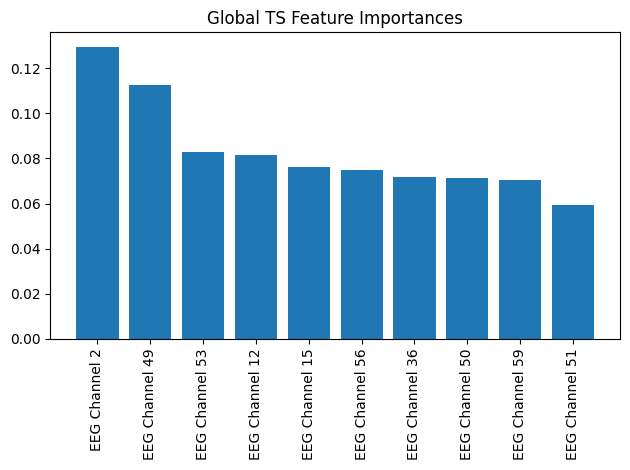

In [ ]:
## Global Weights (Only show top 10)
topk = 10
importances = np.mean(weights,axis = 0)
indices = importances.argsort()[::-1]
indices = indices[:topk]
plt.figure()
plt.title("Global TS Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()


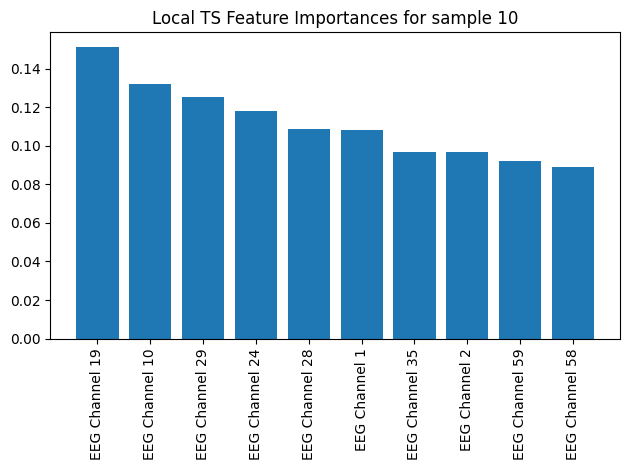

In [ ]:
## Local Weights for sample K, (Only show top 10)
sample = 10
topk = 10
importances = weights[sample]
indices = importances.argsort()[::-1]
indices = indices[:topk]
plt.figure()
plt.title("Local TS Feature Importances for sample " + str(sample))
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()